## Fugue and DuckDB for FastSQL code in Python

Fugue is a python library that allows users to combine python code and sql commands. This gives users the flexibility to switch between python and sql within jupyter notebook or a python script. By default fugue maps your sql code to pandas. 

DuckDB is an in-process SQL OLAP database management system. The speed is very good on even gigabytes of data on local machines. 

Thus the combination of Fugue SQL and DuckDB allows you to use SQL with Python while seamlessly speed up your code.

* [Para poder extraer el input CLIC](https://towardsdatascience.com/fugue-and-duckdb-fast-sql-code-in-python-e2e2dfc0f8eb)

In [1]:
# First we need to setup Fugue, this will let us use the %%fsql cell magic inside Jupyter notebooks.

from fugue_notebook import setup
import fugue_duckdb

setup()

<IPython.core.display.Javascript object>

In [2]:
import os

save_path = f'{os.getcwd()}/Data/raw.parquet'
print(save_path)

/home/bruno/Developing_Learning/Pyhton_Dev_Projects/Cool_Extensions/Data/raw.parquet


In [3]:
#Lets try using just pandas:

import pandas as pd

df = pd.read_parquet(save_path)
df

: 

: 

### Now using Fugue + DuckDB

In [4]:
%%fsql duck

LOAD '{{save_path}}'
PRINT

,Open,High,Low,Close,Volume,Close_time,Quote_asset_volume,Number_of_trades,Taker_buy_base_asset_volume,Taker_buy_quote_asset_volume,symbol,time
0,0.000436,0.000436,0.000436,0.000436,2018.0,1509494459999,0.880400,4,0.0,0.000000,SNGLSETH,2017-11-01 00:00:00
1,0.000436,0.000436,0.000421,0.000425,2497.0,1509494519999,1.074549,8,893.0,0.379605,SNGLSETH,2017-11-01 00:01:00
2,0.000425,0.000428,0.000425,0.000428,2671.0,1509494579999,1.139313,3,2671.0,1.139313,SNGLSETH,2017-11-01 00:02:00
3,0.000428,0.000428,0.000428,0.000428,1773.0,1509494639999,0.758578,4,1773.0,0.758578,SNGLSETH,2017-11-01 00:03:00
4,0.000428,0.000428,0.000428,0.000428,887.0,1509494699999,0.379715,4,887.0,0.379715,SNGLSETH,2017-11-01 00:04:00
5,0.000428,0.000428,0.000428,0.000428,0.0,1509494759999,0.000000,0,0.0,0.000000,SNGLSETH,2017-11-01 00:05:00
6,0.000428,0.000428,0.000428,0.000428,0.0,1509494819999,0.000000,0,0.0,0.000000,SNGLSETH,2017-11-01 00:06:00
7,0.000428,0.000428,0.000428,0.000428,0.0,1509494879999,0.000000,0,0.0,0.000000,SNGLSETH,2017-11-01 00:07:00
8,0.000428,0.000428,0.000428,0.000428,0.0,1509494939999,0.000000,0,0.0,0.000000,SNGLSETH,2017-11-01 00:08:00
9,0.000428,0.000428,0.000428,0.000428,0.0,1509494999999,0.000000,0,0.0,0.000000,SNGLSETH,2017-11-01 00:09:00


In [4]:
%%fsql duck

LOAD '{{save_path}}'

SELECT * WHERE symbol LIKE '%USDT'

SELECT 
        symbol,
        date_trunc('day',time) AS date,
        SUM(Number_of_trades) AS trades
GROUP BY 1,2


SELECT
        symbol,
        AVG(trades) AS trades
GROUP BY 1
ORDER BY 2 DESC
LIMIT 3


YIELD DATAFRAME AS top_symbols
PRINT

,symbol,trades
0,BTCUSDT,204608.145695
1,ETHUSDT,121244.543046
2,LTCUSDT,50804.761468


In [9]:
top_symbols.as_pandas()

,symbol,trades
0,BTCUSDT,204608.145695
1,ETHUSDT,121244.543046
2,LTCUSDT,50804.761468


### Assign names to Intermediate outputs

In [5]:
%%fsql duck

src = LOAD '{{save_path}}'

SELECT src.*
FROM src
INNER JOIN top_symbols
ON src.symbol = top_symbols.symbol
YIELD DATAFRAME AS top_data

: 

: 

In [6]:
%%fsql duck

src = LOAD '{{save_path}}'

SELECT COUNT(*) AS count
FROM src
PRINT

,count
0,46674268


In [4]:
import pandas as pd

def plot_by(df:pd.DataFrame, by, y) -> None:
    for name, group in df.groupby(by):
        group.plot(x="time", y=y, title=name)

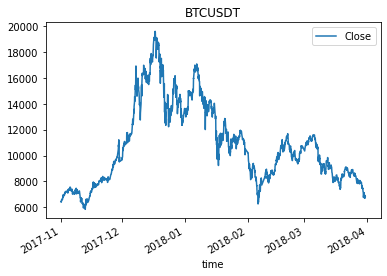

In [5]:
%%fsql duck

LOAD '{{save_path}}'

SELECT * WHERE symbol = 'BTCUSDT'

SAMPLE 1 PERCENT SEED 0

SELECT * ORDER BY time

OUTPUT USING plot_by(by='symbol',y='Close')

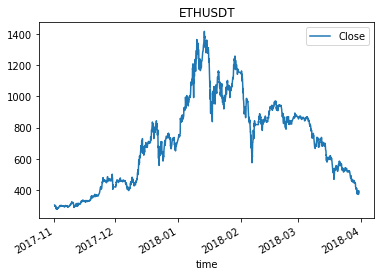

In [6]:
%%fsql duck

LOAD '{{save_path}}'

SELECT * WHERE symbol = 'ETHUSDT'

SAMPLE 1 PERCENT SEED 0

SELECT * ORDER BY time

OUTPUT USING plot_by(by='symbol',y='Close')

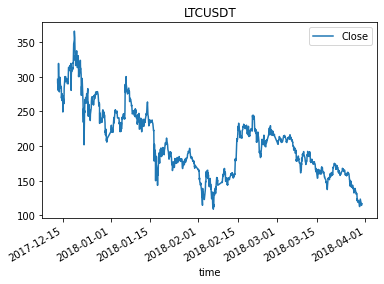

In [7]:
%%fsql duck

LOAD '{{save_path}}'

SELECT * WHERE symbol = 'LTCUSDT'

SAMPLE 1 PERCENT SEED 0

SELECT * ORDER BY time

OUTPUT USING plot_by(by='symbol',y='Close')

### Transform data

In [36]:
# schema: *,macd:double
def macd(df:pd.DataFrame) -> pd.DataFrame:
  """get macd - the indicator of the trend of the timeseries"""
  import pandas_ta
  macd = df.ta.macd(close='close', fast=12, slow=26, signal=9)
  return df.assign(macd=macd.iloc[:,2])

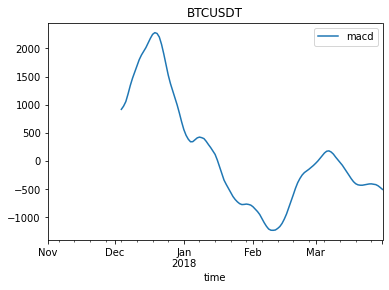

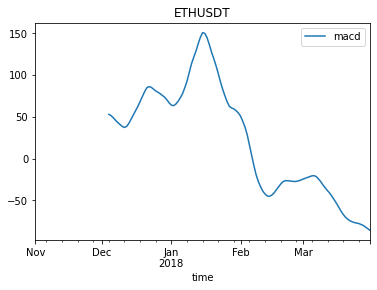

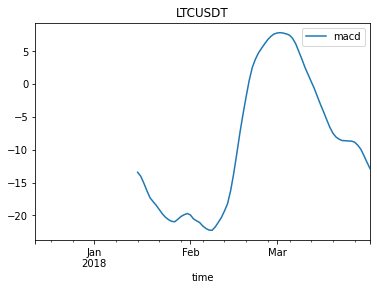

In [38]:
%%fsql duck

LOAD '{{save_path}}'

SELECT * WHERE symbol IN ('LTCUSDT','ETHUSDT','BTCUSDT')

SELECT 
        symbol,
        date_trunc('day',time) AS time,
        min_by(Open, time) AS open,
        MAX(High) AS high,
        MIN(Low) AS low,
        max_by(Close, time) AS close,
        SUM(Number_of_trades) AS trades,
        SUM(Volume) AS volume
GROUP BY 1,2


TRANSFORM PREPARTITION BY symbol PRESORT time USING macd


SELECT * ORDER BY time
OUTPUT USING plot_by(by='symbol',y='macd')

## Fugue + DuckDB in Production

To bring FugueSQL out of Jupyter notebooks and into Python scripts, all we need to do is wrap the FugueSQL query inside a fsql class. We can then call the .run() method and choose an execution engine to be "duck".

In [ ]:
import fugue_duckdb
query = """ src = LOAD "{{save_path}}"
            SELECT * WHERE symbol LIKE '%USDT'
            SELECT symbol, date_trunc('day',time) AS date, SUM(Number_of_trades) AS trades GROUP BY 1,2
            top_symbols = SELECT symbol, AVG(trades) AS trades GROUP BY 1 ORDER BY 2 DESC LIMIT 4
            
            SELECT src.* FROM src INNER JOIN top_symbols ON src.symbol = top_symbols.symbol
            SELECT
                symbol,
                date_trunc('day', time) AS time,
                min_by(Open, time) AS open,
                MAX(High) AS high,
                MIN(Low) AS low,
                max_by(Close, time) AS close,
                SUM(Number_of_trades) AS trades,
                SUM(Volume) AS volume
            GROUP BY 1, 2
            TRANSFORM PREPARTITION BY symbol PRESORT time
            USING macd
            SELECT * ORDER BY time
            OUTPUT USING plot_by(by='symbol', y="macd")
            """
fsql(query).run("duck")

## For Spark and DaskFrames

You don't need to modify the logic of the query, just modify the magic word.

Fugue also has support for Spark, Dask, and cuDF (through blazingSQL) as backends.

In [ ]:
#To run on pandas use:
!pip install fugue[sql]

#To run on spark, dask use:
!pip install fugue[sql, spark]
!pip install fugue[sql, dask]
!pip install fugue[all]

In [ ]:
%%fsql spark

SELECT *
FROM df
TRANSFORM USING str_concat(delimiter='_')
PRINT

In [ ]:
# schema: *
def get_median(df:pd.DataFrame) -> List[Dict[str,Any]]:
    return [{'col1':df['col1'].median(), 'col2':df['col2'].iloc[0]}]

In [ ]:
%%fsql spark

SELECT *
FROM df
TRANSFORM PREPARTITION BY col2 USING get_median
PRINT

### Spark Production

In [ ]:
from fugue_sql import fsql
import fugue_spark

fsql(
    """SELECT * 
        FROM df 
        TRANSFORM PREPARTITION BY col2 USING get_median
        PRINT"""
).run("spark")